In [1]:
import torch
import networkx as nx
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from sklearn.metrics import r2_score 
import time 
from matplotlib import pyplot as plt 
import torch_geometric as pyg

import sys 
sys.path.append('../src/')

from src.models.NN import NN
from src.data.LincsDataset import LincsDataset
from src.data.pygLincsDataset import pygLincsDataset
from src.models import utils 

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
if torch.cuda.is_available() & True:
    device = 'cuda'
else: 
    device = 'cpu'

print('using device', device)

using device cuda


In [3]:
data = torch.load('./processed_data/Data.pt')

In [4]:
train_ids = np.load('./processed_data/train_obs.npy', allow_pickle=True)
train_dataset = pygLincsDataset(root='./processed_data/', sig_ids=train_ids, data=data)
train_loader = pyg.loader.DataLoader(train_dataset, batch_size=100, num_workers=4, shuffle=True)

test_ids = np.load('./processed_data/test_obs.npy', allow_pickle=True)
test_dataset = pygLincsDataset(root='./processed_data/', sig_ids=test_ids, data=data)
test_loader = pyg.loader.DataLoader(test_dataset, batch_size=100, num_workers=4, shuffle=True)

In [45]:
model = pyg.nn.models.GAT(in_channels=1, 
                          hidden_channels=256, 
                          num_layers=3,
                          out_channels=1, 
                          dropout=0., 
                          act='elu',
                          act_first=False,
                          act_kwargs=None,
                          norm_kwargs=None,
                          jk='cat').to(device)

n_params = sum([p.numel() for p in model.parameters()])
print('# params', n_params)

# params 134401


In [46]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.MSELoss()

In [48]:
for epoch in range(50):
    big_tic = time.time()
    model = model.train()
    losses = []
    for i,(batch) in enumerate(train_loader): 
        tic = time.time()
        optim.zero_grad() 

        yhat = model(edge_index=batch.edge_index.to(device), x=batch.x.to(device))
        
        #  select output nodes
        yhat = yhat[batch.output_node_mask]
        y = batch.y.to(device)[batch.output_node_mask]

        loss = crit(yhat, y)
        loss.backward()
        optim.step()

        with torch.no_grad(): 
            
            B = len(batch.sig_id)

            yhat = yhat.view(B, -1).detach().cpu().numpy() 
            y = y.view(B, -1).detach().cpu().numpy() 
            
            r2 = r2_score(y, yhat, multioutput='variance_weighted')
            r_flat = np.corrcoef(y.ravel(), yhat.ravel())[0,1]
            losses.append(loss.item())

            print(f'epoch: {epoch} || batch: {i}/{len(train_loader)} || loss: {loss.item():.3f} || r2: {r2:.3f} || r (flat): {r_flat:.2f} || elapsed: {(time.time() - tic):.2f} s' , end='\r')

    loss_train = np.mean(losses)

    y,yhat,sig_ids = utils.predict_gnn(test_loader, model, data, device)
    r2_test = r2_score(y, yhat, multioutput='variance_weighted')
    r_flat_test = np.corrcoef(y.ravel(), yhat.ravel())[0,1]

    print(f'Epoch: {epoch} || loss (train): {loss_train:.3f} || r2 (test): {r2_test:.2f} || r flat (test): {r_flat_test:.2f} || elapsed: {(time.time() - big_tic)/60:.2f} min')

KeyboardInterrupt: 

In [ ]:
y,yhat,sig_ids = utils.predict_gnn(test_loader, model, data, device)

In [32]:
r2_score(y, yhat, multioutput='variance_weighted')

-0.10784747560158672

In [33]:
np.corrcoef(y.ravel(), yhat.ravel())[0,1]

0.18730936171436643

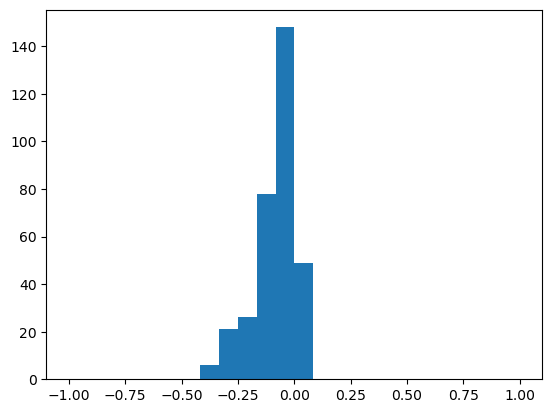

In [34]:
gene_r2 = r2_score(y, yhat, multioutput='raw_values')
np.save('./nn_test_gene_r2.npy', gene_r2)

plt.figure()
plt.hist(gene_r2, bins=np.linspace(-1,1,25))
plt.show()